# Report

In this notebook we report insurance cost

In [2]:
import os
from functools import partial

In [3]:
import joblib
import pandas as pd

In [4]:
import data
import metrics

In [5]:
%load_ext autoreload
%autoreload 2

## Exploratory analysis

In [6]:
df_data= pd.read_csv('train_regression.csv', sep=',')

In [7]:
df_data.head(5)

,age,sex,bmi,children,smoker,region,y
0,43,female,25.080,0,no,northeast,7325.04820
1,39,male,35.300,2,yes,southwest,40103.89000
2,45,female,30.495,1,yes,northwest,39725.51805
3,19,female,32.900,0,no,southwest,1748.77400
4,60,male,39.900,0,yes,southwest,48173.36100


In [8]:
df_data.describe()

,age,bmi,children,y
count,896.000000,896.000000,896.000000,896.000000
mean,39.234375,30.542617,1.099330,13379.688250
std,14.212151,5.984036,1.205277,12110.713713
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.272500,0.000000,4819.842913
50%,39.000000,30.230000,1.000000,9556.297050
75%,52.000000,34.488750,2.000000,17092.916520
max,64.000000,53.130000,5.000000,62592.873090


In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       896 non-null    int64  
 1   sex       896 non-null    object 
 2   bmi       896 non-null    float64
 3   children  896 non-null    int64  
 4   smoker    896 non-null    object 
 5   region    896 non-null    object 
 6   y         896 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 49.1+ KB


Haciendo una revisión inicial de los datos se identifica que no hay valores nulos en el dataset.
La edad promedio para las personas incluidas en la base es de 39 años y el indice de masa corporal promedio es de 30 (por encima de lo normal y cercano a sobrepeso). El promedio de personas de la base tienen 1 hijo y el 75% de ellos tienen 2 o menos hijos.

In [10]:
df_data.age.quantile(q=[0.25, 0.50, 0.75], interpolation='midpoint')

0.25    27.0
0.50    39.0
0.75    52.0
Name: age, dtype: float64

In [525]:
def transform_age(age):
    if age <=32:
        return "[18 to 32]"
    elif age<=48:
        return "[33 to 48]"
    else:
        return "[older than 48]"

df_data['age_range'] = df_data['age'].apply(transform_age)

In [12]:
def transform_bmi(bmi):
    if bmi <=18.5:
        return "Underweight"
    elif bmi<=24.9:
        return "Healthy weight"
    elif bmi<=29.9:
        return "Overweight"
    else:
        return "Obesity"

df_data['bmi_range'] = df_data['bmi'].apply(transform_bmi)

In [13]:
dict_data = df_data[["age_range","bmi_range","y"]].groupby(["age_range","bmi_range"]).mean().to_dict()['y']

In [14]:
dict_data[('[18 to 27]', 'Healthy weight')]

6458.871772448978

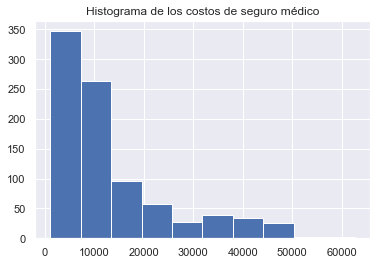

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

df_data.y.hist()
plt.title("Histograma de los costos de seguro médico");

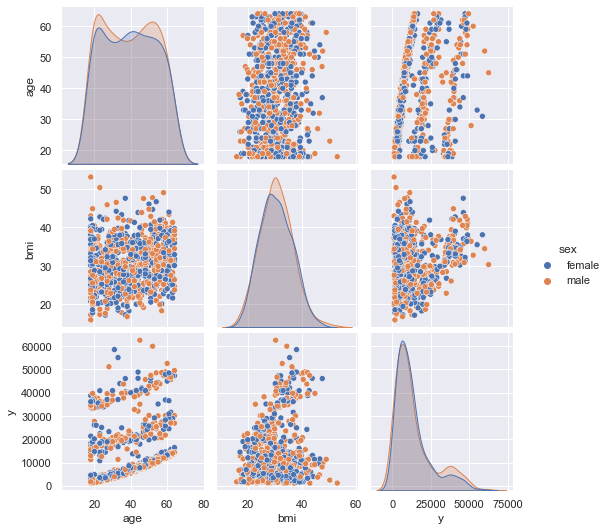

In [16]:
sns.pairplot(df_data.drop("children", axis=1), hue="sex");

C:\Users\Andre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


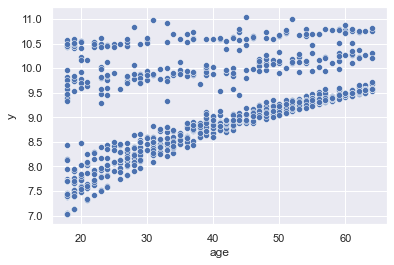

In [31]:
sns.scatterplot(df_data['age'], np.log(df_data['y']));

C:\Users\Andre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


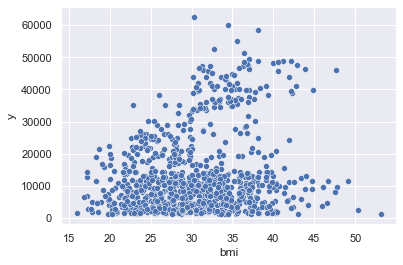

In [19]:
sns.scatterplot(df_data['bmi'], df_data['y']);

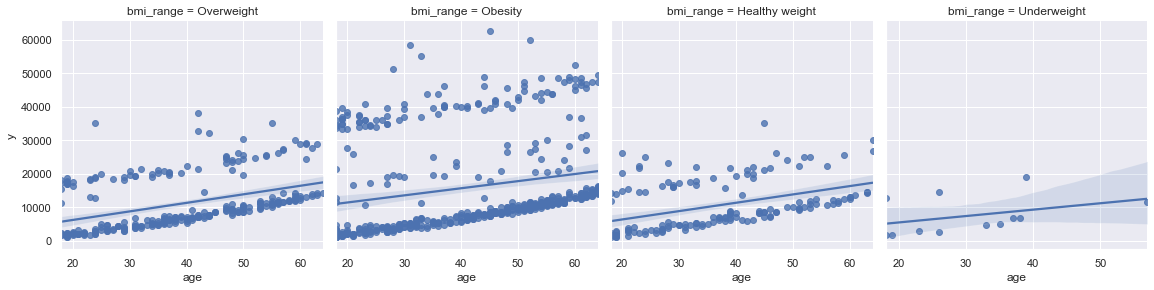

In [21]:
grid = sns.lmplot(x = "age", y = "y", col = "bmi_range", sharex=False, col_wrap = 4, data = df_data, height=4)

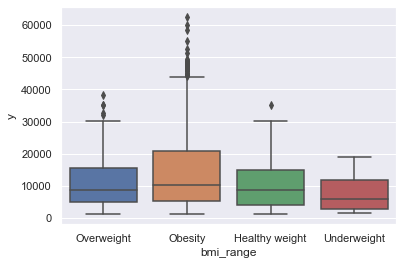

In [174]:
sns.boxplot(data=df_data, x= "bmi_range", y="y");

C:\Users\Andre\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


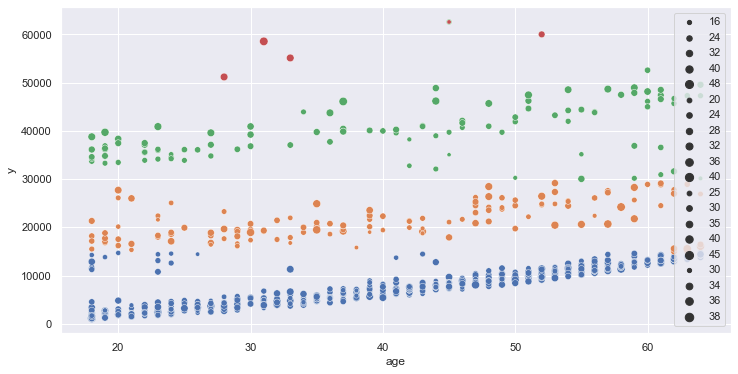

In [338]:
data1=df_data[df_data['y']<=15000]
data2=df_data[(df_data['y']>15000) & (df_data['y']<=30000)]
data3=df_data[df_data['y']>30000]

data1.bmi = data1.bmi.apply(lambda x : int(round(x)))
data2.bmi = data2.bmi.apply(lambda x : int(round(x)))
data3.bmi = data3.bmi.apply(lambda x : int(round(x)))

posible_outliers1 = df_data[(df_data['y']>50000) & (df_data['age']>20) & (df_data['age']<=30)]
posible_outliers2 = df_data[(df_data['y']>50000) & (df_data['age']>30) & (df_data['age']<60)]
posible_outliers = pd.concat([posible_outliers1, posible_outliers2])
posible_outliers.bmi = posible_outliers.bmi.apply(lambda x : int(round(x)))

plt.figure(figsize=(12,6))
sns.scatterplot(data=data1, x='age', y='y', size='bmi');
sns.scatterplot(data=data2, x='age', y='y', size='bmi');
sns.scatterplot(data=data3, x='age', y='y', size='bmi');
sns.scatterplot(data=posible_outliers, x='age', y='y', size='bmi');
plt.legend(loc='upper right');

In [325]:
#Eliminar posibles outliers del dataset 
data_so = df_data.drop(labels=list(posible_outliers.index), axis=0)
data_so.drop(columns=["bmi_range","age_range"], inplace=True)
data_so.to_csv("train_regression_so.csv",index=False)

In [16]:
df_data['sex'].value_counts()

male      459
female    437
Name: sex, dtype: int64

El dataset parece estar balanceado en términos del género de las personas

In [17]:
df_data['smoker'].value_counts()

no     708
yes    188
Name: smoker, dtype: int64

In [608]:
df_data['bmi_range'].value_counts()

Obesity           471
Overweight        261
Healthy weight    152
Underweight        12
Name: bmi_range, dtype: int64

Se tiene que del total de personas, 188 son fumadores, habrá que revisar si esta caracteristica se encuentra asociada con un mayor BMI y posiblemente mayores costos de atención.

In [18]:
df_data['region'].value_counts()

northeast    230
southeast    229
northwest    226
southwest    211
Name: region, dtype: int64

El dataset también se encuentra balanceado respecto a las regiones

In [19]:
df_data[['region','y']].groupby('region').mean()

,y
region,
northeast,13569.477583
northwest,12622.239959
southeast,14110.190502
southwest,13191.284228


In [20]:
df_data[['sex','y']].groupby('sex').mean()

,y
sex,
female,12943.455455
male,13795.012283


El costo promedio de atención para los hombres es un poco mas alto que para las mujeres, así mismo en la region sureste los costos son mas elevados en comparación con otras regiones.

In [36]:
def evaluate_model(*, model, metric, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    train_error = metric(y_train, train_predictions)
    test_error = metric(y_test, test_predictions)
    return {
        "train_predictions": train_predictions,
        "test_predictions": test_predictions,
        "train_error": train_error,
        "test_error": test_error
    }

def print_report(*, model, evaluation):
    print(f"Model used:\n\t{reg}")
    print(f"Error:\n\ttrain set {evaluation['train_error']}\n\ttest error: {evaluation['test_error']}")

In [37]:
models_dir = "models"

In [38]:
dataset_path = "train_regression.csv"

In [39]:
dataset = data.get_dataset(
    partial(pd.read_csv, filepath_or_buffer=dataset_path),
    splits=("train", "test")
)

In [40]:
dataset

{'train': (     age     sex     bmi  children smoker     region        age_range  \
  585   41    male  28.405         1     no  northwest       [40 to 52]   
  765   51    male  37.000         0     no  southwest       [40 to 52]   
  577   47    male  29.800         3    yes  southwest       [40 to 52]   
  247   27  female  21.470         0     no  northwest       [18 to 27]   
  452   50  female  27.830         3     no  southeast       [40 to 52]   
  ..   ...     ...     ...       ...    ...        ...              ...   
  715   51  female  21.560         1     no  southeast       [40 to 52]   
  767   53    male  34.105         0    yes  northeast  [older than 52]   
  72    35    male  17.860         1     no  northwest       [28 to 39]   
  235   62    male  37.400         0     no  southwest  [older than 52]   
  37    31  female  25.740         0     no  southeast       [28 to 39]   
  
            bmi_range  
  585      Overweight  
  765         Obesity  
  577      Overw

## Baseline


In [26]:
model_path = os.path.join("models", "2021-06-10 16-20", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('average-price-per-bmi-regressor',
                 AveragePricePerBMIRegressor())])
Error:
	train set 7509.7855008652
	test error: 8100.979075614957


## Linear Regression Model 


In [27]:
model_path = os.path.join("models", "2021-06-10 20-18", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('linear-regressor', LinearRegression())])
Error:
	train set 3867.03234093368
	test error: 3740.898369690209


**Error Analysis**

What can you learn about the errors your model is making? Try this:

* Discretize the errors your model is making by some categorical variables.
* Sort and discretize the errors your model is making and see what the features have in common in those cases. 

## Linear regression with Feature Engineering


In [606]:
model_path = os.path.join("models", "2021-06-12 20-54", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures(interaction_only=True)),
                ('standard-scaler', StandardScaler()),
                ('linear-regressor', LinearRegression())])
Error:
	train set 3097.140361447184
	test error: 2878.4038547181076


In [ ]:
model_path = os.path.join("models", "2021-06-12 20-54", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

**Error Analysis**

What can you learn about the errors your model is making? Try this:

* Discretize the errors your model is making by some categorical variables.
* Sort or discretize the errors your model is making and see what the features have in common in those cases. 

## Random Forest


In [29]:
model_path = os.path.join("models", "2021-06-10 21-00", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('random-forest-regressor',
                 RandomForestRegressor(max_depth=3, min_samples_split=6,
                                       n_estimators=150))])
Error:
	train set 2284.2332171398853
	test error: 2257.539109870745


In [30]:
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('random-forest-regressor',
                 RandomForestRegressor(max_depth=3, min_samples_split=6,
                                       n_estimators=150))])
Error:
	train set 0.8516686295215528
	test error: 0.8817102131320739


**Error Analysis**

What can you learn about the errors your model is making? Try this:

* Discretize the errors your model is making by some categorical variables.
* Sort or discretize the errors your model is making and see what the features have in common in those cases. 

## Gradient Boosting

In [35]:
model_path = os.path.join("models", "2021-06-10 20-54", "model.joblib")

reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('gradient-boosting-regressor',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=130,
                                           subsample=1))])
Error:
	train set 1852.6243830454014
	test error: 2131.871344255011


In [36]:
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('gradient-boosting-regressor',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=130,
                                           subsample=1))])
Error:
	train set 0.891558673768509
	test error: 0.8879223751312801


## Stacking

In [37]:
model_path = os.path.join("models", "2021-06-10 22-46", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('stacking-regressor',
                 StackingRegressor(estimators=[('lr', Ridge()),
                                               ('dt', DecisionTreeRegressor())],
                                   final_estimator=RandomForestRegressor(max_depth=3,
                                                                         min_samples_split=6,
                                                                         n_estimators=150)))])
Error:
	train set 2366.743694177519
	test error: 2494.929969826624


In [38]:
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('stacking-regressor',
                 StackingRegressor(estimators=[('lr', Ridge()),
                                               ('dt', DecisionTreeRegressor())],
                                   final_estimator=RandomForestRegressor(max_depth=3,
                                                                         min_samples_split=6,
                                                                         n_estimators=150)))])
Error:
	train set 0.861389226537737
	test error: 0.8674509569293054


## Gradient Boosting with feature Engineering

In [607]:
model_path = os.path.join("models", "2021-06-14 03-35", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures(interaction_only=True)),
                ('standard-scaler', StandardScaler()),
                ('gradient-boosting-regressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=2,
                                           n_estimators=145))])
Error:
	train set 2375.95768265231
	test error: 1981.594367084202


In [596]:
X_test_reto = pd.read_csv("test_regression_students.csv", sep=",")
X_test_reto["y"]=0
X_test_reto.to_csv("test_regression_students_y.csv",index=False)

In [597]:
dataset_path = "test_regression_students_y.csv"

dataset_reto = data.get_dataset(
    partial(pd.read_csv, filepath_or_buffer=dataset_path),
    splits=("train", "test")
)

In [598]:
model = joblib.load(model_path)

X_test_reto=dataset_reto["test"][0]

In [599]:
test_predictions = model.predict(X_test_reto)

In [600]:
test_predictions.shape

(442,)

In [601]:
import requests
import json

In [604]:
URL = "https://qzbbjszmjk.execute-api.us-east-1.amazonaws.com/dev"

results = {"id": "ALEJANDRO JARAMILLO MIRA; CAROLINA GARCÍA PATIÑO; JUAN PABLO GUTIÉRREZ MURIEL; ROBIN ANDRES SOTO HINCAPIE","email": "alejandro.jaramillom@udea.edu.co", "task_type": "Regression" ,"predictions": list(test_predictions)}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

r = requests.post(url= URL+"/benchmarkin/", data = json.dumps(results) , headers=headers)

In [605]:
r.text

'{"MAE":2500.8388872091373}'

In [208]:
X_test = dataset["test"][0].reset_index()
y_true = dataset["test"][1].reset_index()["y"]
y_pred = pd.Series(evaluation["test_predictions"], name="Prediction")

In [209]:
pred_data=X_test.join([y_true , y_pred])

In [210]:
pred_data["error"]=np.abs(pred_data["y"]-pred_data["Prediction"])

In [211]:
error_data = pred_data.sort_values(by=["error"], ascending=False).head(30)

error_data.sort_values(by=["error"], ascending=False)

,index,age,sex,bmi,children,smoker,region,age_range,bmi_range,y,Prediction,error
192,289,44,male,29.735,2,no,northeast,[40 to 52],Overweight,32108.66282,10195.510003,21913.152817
5,6,55,female,26.800,1,no,southwest,[older than 52],Overweight,35160.13457,14831.849734,20328.284836
165,637,21,female,32.680,2,no,northwest,[18 to 27],Obesity,26018.95052,6212.238474,19806.712046
15,518,59,female,34.800,2,no,southwest,[older than 52],Obesity,36910.60803,18889.964619,18020.643411
214,354,28,female,24.320,1,no,northeast,[28 to 39],Healthy weight,23288.92840,5451.372628,17837.555772
111,754,31,female,38.095,1,yes,northeast,[28 to 39],Obesity,58571.07448,43224.244325,15346.830155
160,16,23,female,24.225,2,no,northeast,[18 to 27],Healthy weight,22395.74424,7407.940362,14987.803878
87,216,60,female,25.840,0,no,northwest,[older than 52],Overweight,28923.13692,14824.409610,14098.727310
124,50,58,female,41.910,0,no,southeast,[older than 52],Obesity,24227.33724,11387.393263,12839.943977
66,710,29,male,29.735,2,no,northwest,[28 to 39],Overweight,18157.87600,6246.328111,11911.547889


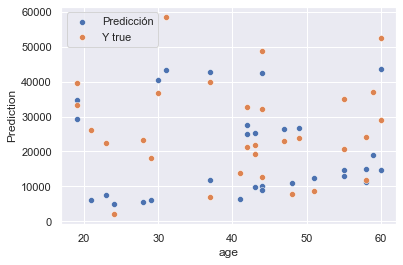

In [212]:
sns.scatterplot(data=error_data, x="age", y="Prediction", label="Predicción");
sns.scatterplot(data=error_data, x="age", y="y", label="Y true");

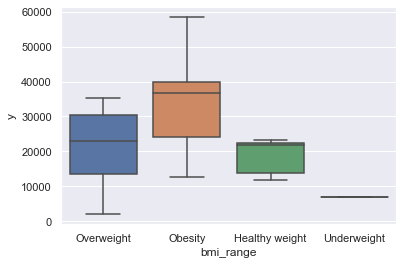

In [213]:
sns.boxplot(data=error_data, x= "bmi_range", y="y");

In [214]:
error_data["bmi_range"].value_counts()

Obesity           13
Overweight        11
Healthy weight     5
Underweight        1
Name: bmi_range, dtype: int64

In [215]:
error_data["age_range"].value_counts()

[40 to 52]         12
[older than 52]     7
[28 to 39]          6
[18 to 27]          5
Name: age_range, dtype: int64

In [216]:
error_data["smoker"].value_counts()

no     18
yes    12
Name: smoker, dtype: int64

In [217]:
error_data["children"].value_counts()

0    15
2     9
1     5
3     1
Name: children, dtype: int64

In [230]:
from sklearn.cluster import KMeans

## Modelo de votación agrupando los datos por rango de costo y edad

In [347]:

data_cluster=df_data.copy()
data_cluster.drop(["y", "age_range", "bmi_range"], axis=1, inplace=True)


data_cluster = pd.get_dummies(data_cluster, columns=["sex", "smoker", "region"], prefix=["sex", "smoker", "region"])

model = KMeans(n_clusters=3)
model.fit(data_cluster)

# Prediction on the entire data
all_predictions = pd.Series(model.predict(data_cluster), name="class")

In [348]:
data_cluster2 = data_cluster.join([all_predictions,df_data["y"]])

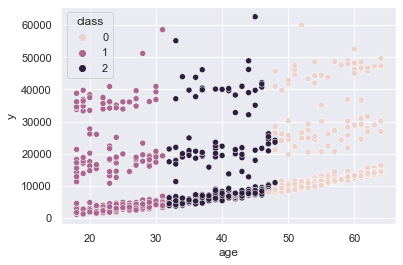

In [611]:


sns.scatterplot(data=data_cluster2, x='age', y='y', hue="class");


In [526]:
data1=df_data[(df_data['y']<=9000) & (df_data['age']<=32)]
data2=df_data[(df_data['y']>9000) & (df_data['y'] <= 30000) & (df_data['age']<=32)]
data3=df_data[(df_data['y']>30000) &  (df_data['y']<50000)  & (df_data['age']<=32)]

data4=df_data[(df_data['y']<=12000) & (df_data['age'] > 32) & (df_data['age']<=48)]
data5=df_data[(df_data['y']>12000) & (df_data['y'] <= 30000) & (df_data['age'] > 32) & (df_data['age']<=48)]
data6=df_data[(df_data['y']>30000) & (df_data['y']<50000)  & (df_data['age'] > 32) & (df_data['age']<=48)]

data7=df_data[(df_data['y']<=19000) & (df_data['age']> 48)]
data8=df_data[(df_data['y']>19000) & (df_data['y'] <= 35000) & (df_data['age']>48)]
data9=df_data[(df_data['y']>35000) & (df_data['y']<50000)  & (df_data['age']>48)]

data_m1 = pd.concat([data1, data4, data7])
data_m2 = pd.concat([data2, data5, data8])
data_m3 = pd.concat([data3, data6, data9])

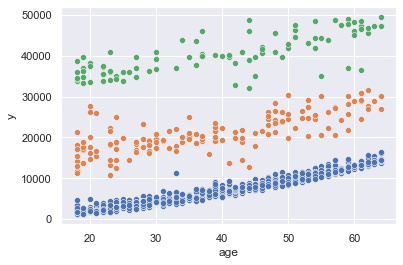

In [612]:
sns.scatterplot(data=data_m1, x='age', y='y');
sns.scatterplot(data=data_m2, x='age', y='y');
sns.scatterplot(data=data_m3, x='age', y='y');

In [527]:
X_m1 = pd.get_dummies(data_m1.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])

X_m2 = pd.get_dummies(data_m2.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])

X_m3 = pd.get_dummies(data_m3.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])

In [528]:
y_m1=data_m1["y"]
y_m2=data_m2["y"]
y_m3=data_m3["y"]

In [529]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

In [561]:
# MODELO 1 
X_train, X_test, y_train, y_test = train_test_split(X_m1, y_m1, test_size=0.2, random_state=42)

regr1 = RandomForestRegressor(max_depth=4)
regr1.fit(X_train, y_train)

score_train = regr1.score(X_train, y_train)
score_test = regr1.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.9799537267602186
Test score: 0.9780073264706023


In [476]:
# MODELO 2
X_train, X_test, y_train, y_test = train_test_split(X_m2, y_m2, test_size=0.2, random_state=42)

regr = RandomForestRegressor()
regr.fit(X_train, y_train)

score_train = regr.score(X_train, y_train)
score_test = regr.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.9370749243510312
Test score: 0.6283318022567574


In [559]:
# MODELO 2.1

regr2=make_pipeline(PolynomialFeatures(3),RandomForestRegressor(max_depth=5))
regr2.fit(X_train, y_train)

score_train = regr2.score(X_train, y_train)
score_test = regr2.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.9792654464217649
Test score: 0.9475649454190905


In [588]:
# MODELO 3
X_train, X_test, y_train, y_test = train_test_split(X_m3, y_m3, test_size=0.2, random_state=42)

regr3=make_pipeline(PolynomialFeatures(4),RandomForestRegressor(max_depth=5))
regr3.fit(X_train, y_train)

score_train = regr3.score(X_train, y_train)
score_test = regr3.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.9822631206729805
Test score: 0.9399140707489193


In [589]:
X_ = pd.get_dummies(df_data.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])
y_ = df_data["y"]

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

er = VotingRegressor([('m1', regr1), ('m2', regr2), ('m3', regr3)])
er.fit(X_train, y_train)

score_train = er.score(X_train, y_train)
score_test = er.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.9036691233547498
Test score: 0.8531019436863267


In [580]:
X_test_reto2 = pd.get_dummies(X_test_reto, columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])
test_predictions2 = er.predict(X_test_reto2)

In [581]:
test_predictions2.shape

(442,)

In [582]:
results = {"id": "ALEJANDRO JARAMILLO MIRA; CAROLINA GARCÍA PATIÑO; JUAN PABLO GUTIÉRREZ MURIEL; ROBIN ANDRES SOTO HINCAPIE","email": "robin.soto@udea.edu.co", "task_type": "Regression" ,"predictions": list(test_predictions2)}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

r = requests.post(url= URL+"/benchmarkin/", data = json.dumps(results) , headers=headers)

In [590]:
r.text

'{"MAE":2685.756577822066}'